In [1]:
import torch
import torchaudio

import os
import sys
import argparse
sys.path.append('quality')

from librosa.effects import trim
from librosa.util import normalize
from soundfile import write
import numpy as np
import matplotlib.pyplot as plt

from quality.utils import butter_lp, butter_hp
from quality.qual import kick_qual
from quality.decay import env_qual, rms_qual
from quality.tonality import frq_qual, ihd_qual
from quality.response import res_qual

from torchaudio import load

datapath = "../sampleset/full"

Fs = 44100

C:\Users\damen\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\damen\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
def load_sample(path):
    sample = torchaudio.load(path)[0][0].numpy()
    return normalize(butter_hp(trim(sample, top_db=50)[0],10))

def save_sample(sample, path):
    write(target + "/" + path, sample, Fs)

def layer_lowhigh(sample1, sample2, freq=400):
    lp = butter_lp(sample1, freq, order=3)
    hp = butter_hp(sample2, freq, order=4)
    n = max(len(lp), len(hp))
    out = np.empty(n)
    for i in range(0,min(len(lp), len(hp))):
        out[i] = lp[i] + hp[i]
    for i in range(min(len(lp), len(hp)), n):
        if i >= len(lp):
            out[i] = hp[i]
        else:
            out[i] = lp[i]
    return normalize(out)

def sort_low(sample):
    return 5 * env_qual(sample) + rms_qual(sample) + frq_qual(sample)

def sort_high(sample):
    return res_qual(sample) + ihd_qual(sample)

In [3]:
import logging
import librosa
import pescador
import os
import numpy as np


LOGGER = logging.getLogger('wavegan')
LOGGER.setLevel(logging.DEBUG)


def file_sample_generator(filepath, window_length=32768, fs=44100):
    """
    Audio sample generator
    """
    try:
        audio_data = torchaudio.load(filepath)[0][0].numpy()

        # Clip amplitude
        max_amp = np.max(np.abs(audio_data))
        if max_amp > 1:
            audio_data /= max_amp
    except Exception as e:
        LOGGER.error('Could not load {}: {}'.format(filepath, str(e)))
        raise StopIteration()

    audio_len = len(audio_data)

    # Pad audio to at least a single frame
    if audio_len < window_length:
        pad_length = window_length - audio_len
        left_pad = 0 # we want all kicks to start at 0
        right_pad = pad_length - left_pad

        audio_data = np.pad(audio_data, (left_pad, right_pad), mode='constant')
        audio_len = len(audio_data)

    while True:
        if audio_len == window_length:
            # If we only have a single frame's worth of audio, just yield the whole audio
            sample = audio_data
        else:
            # Sample a random window from the audio file
            # start_idx = np.random.randint(0, audio_len - window_length)
            start_idx = 0 # start at the start
            end_idx = start_idx + window_length
            sample = audio_data[start_idx:end_idx]
            
            if sample[end_idx-1] != 0.0: # apply some declicking
                h = np.hanning(513)
                for i in range(1,256):
                    sample[end_idx - i] *= h[513 - i]

        sample = sample.astype('float32')
        assert not np.any(np.isnan(sample))

        yield {'X': sample}


def create_batch_generator(audio_filepath_list, batch_size):
    streamers = []
    for audio_filepath in audio_filepath_list:
        s = pescador.Streamer(file_sample_generator, audio_filepath)
        streamers.append(s)

    mux = pescador.ShuffledMux(streamers)
    batch_gen = pescador.buffer_stream(mux, batch_size)

    return batch_gen


def get_all_audio_filepaths(audio_dir):
    return [os.path.join(root, fname)
            for (root, dir_names, file_names) in os.walk(audio_dir, followlinks=True)
            for fname in file_names
            if (fname.lower().endswith('.wav') or fname.lower().endswith('.mp3'))]


def create_data_split(audio_filepath_list, valid_ratio, test_ratio,
                      train_batch_size, valid_size, test_size):
    num_files = len(audio_filepath_list)
    num_valid = int(np.ceil(num_files * valid_ratio))
    num_test = int(np.ceil(num_files * test_ratio))
    num_train = num_files - num_valid - num_test

    assert num_valid > 0
    assert num_test > 0
    assert num_train > 0

    valid_files = audio_filepath_list[:num_valid]
    test_files = audio_filepath_list[num_valid:num_valid + num_test]
    train_files = audio_filepath_list[num_valid + num_test:]

    train_gen = create_batch_generator(train_files, train_batch_size)
    valid_data = next(iter(create_batch_generator(valid_files, valid_size)))
    test_data = next(iter(create_batch_generator(test_files, test_size)))

    return train_gen, valid_data, test_data


In [52]:
full_list = get_all_audio_filepaths(datapath)
train_gen, valid_data, test_data = create_data_split(full_list, 0.1, 0.1, 32, 32, 32)

In [51]:
x = next(iter(train_gen))['X'][0]
plt.plot(x)
plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-51-31d89577a273>, line 6)

In [65]:
def iter_streamer(x, y):
    while True:
        x = x + y
        print(x)
        yield str(x)

a = pescador.Streamer(iter_streamer, 2, 1)
b = pescador.Streamer(iter_streamer, -1, -1)
c = pescador.Streamer(iter_streamer, 0, 0)
mux = pescador.ShuffledMux([a, b, c])
print("".join(mux(max_iter=3)))
print("Pause")
print("".join(mux(max_iter=6)))

3
4
0
340
Pause
-2
3
-3
-4
4
5
-23-3-445


In [63]:
def sort_low(path):
    sample = load_sample(path)
    return 5 * env_qual(sample) + rms_qual(sample) + frq_qual(sample)

def sort_high(path):
    sample = load_sample(path)
    return res_qual(sample) + ihd_qual(sample)

def augmented_batch_gen(datapath, batch_size):
    dataset = get_all_audio_filepaths(datapath)
    N = len(dataset)
    print(f"Found {N} input samples. Sorting...")
    dataset.sort(key=sort_low)
    top_low = dataset[0:N//2]
    dataset.sort(key=sort_high)
    top_high = dataset[0:N//2]

    streamers = []
    for path1 in top_low:
        s = pescador.Streamer(gen_layers, top_high, path1)
        streamers.append(s)
    mux = pescador.ShuffledMux(streamers)
    batch_gen = pescador.buffer_stream(mux, batch_size)
    return batch_gen

def gen_layers(top_high, path1):
    for path2 in top_high:
        sample1 = load_sample(path1)
        sample2 = load_sample(path2)
        sample = layer_lowhigh(sample1, sample2, 400)
        q = kick_qual(sample)
        print(f"Quality {q}")
        if 0 <= q <= 1.5:
            #todo: padding here
            yield {'X': sample}
        else:
            print("Skipped one!")
            continue
        
train_gen_a = iter(augmented_batch_gen(datapath, 32))

Found 456 input samples. Sorting...


In [64]:
batch = None

Quality 1.0054619158782527
Quality 0.6333016706914025
Quality 0.6129999695939268
Quality 0.7543215485069488
Quality 0.5470621526535957
Quality 0.8750216115253695
Quality 0.7292189021313265
Quality 0.43697376535644894
Quality 0.5482828020780981
Quality 0.5500095512293406
Quality 0.5776032411948376
Quality 0.5392489031069044
Quality 0.6726270760376378
Quality 0.5678779384902319
Quality 0.641713740062392
Quality 0.6735523291088228
Quality 0.6018974383303202
Quality 0.49869757090346306
Quality 0.5928965315093928
Quality 0.5336593159598056
Quality 0.5222186876185417
Quality 0.6054462393007782
Quality 0.9446163894230583
Quality 0.5149668703416268
Quality 0.4871044641019149
Quality 0.599716495931977
Quality 0.5786989581690967
Quality 0.7277064923415058
Quality 0.5141146732825395
Quality 0.6745095221748119
Quality 0.5823988044282533
Quality 0.5225178644220421
{'X': array([array([ 0.00021975, -0.00025345,  0.00022217, ...,  0.00391829,
        0.00391447,  0.00391066]),
       array([ 0.0001896

C:\Users\damen\anaconda3\lib\site-packages\pescador\maps.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  output[key] = np.array([x[key] for x in data])


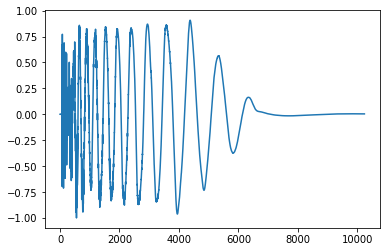

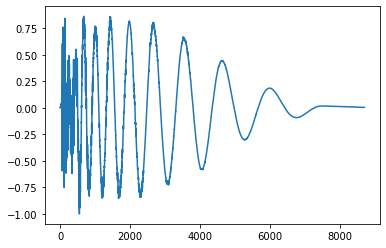

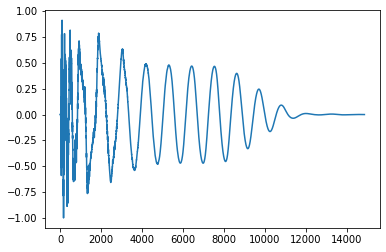

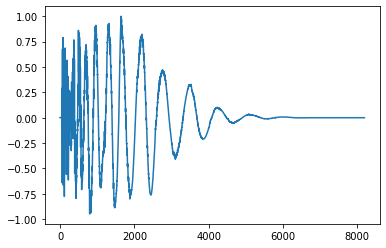

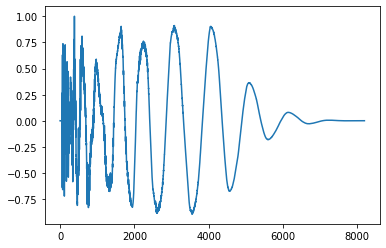

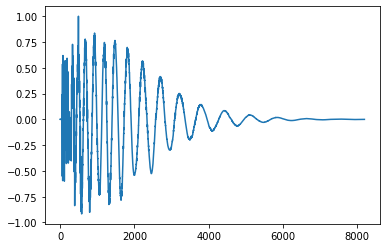

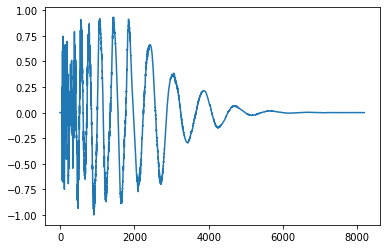

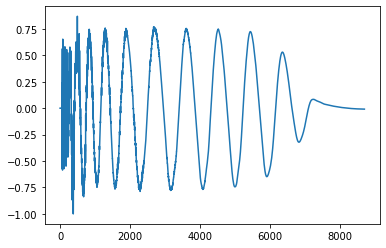

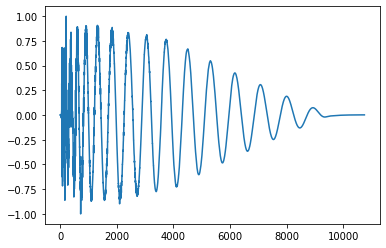

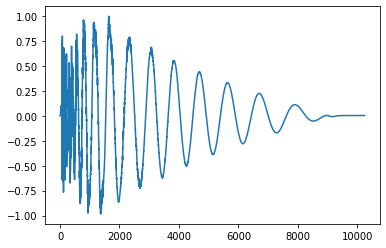

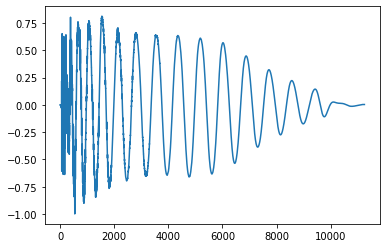

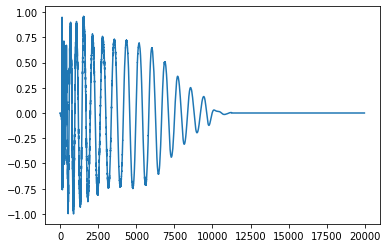

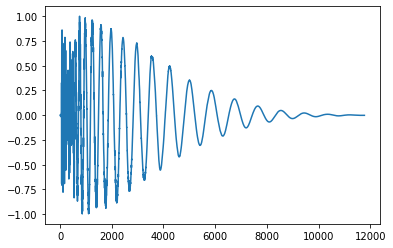

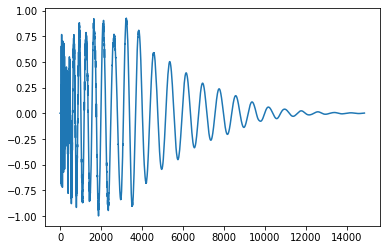

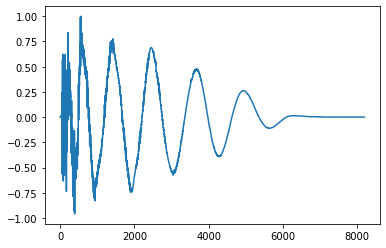

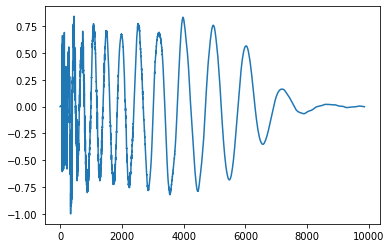

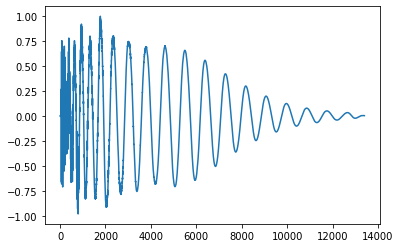

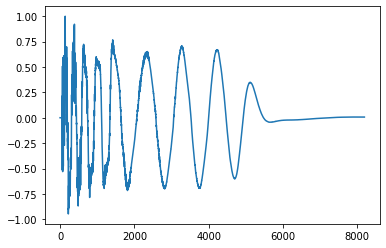

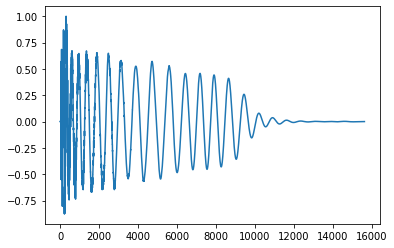

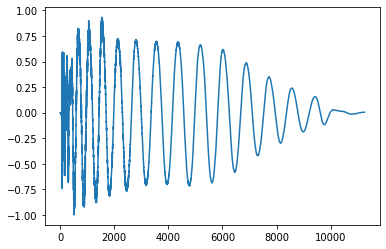

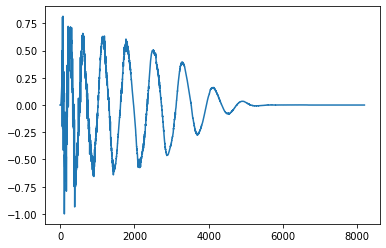

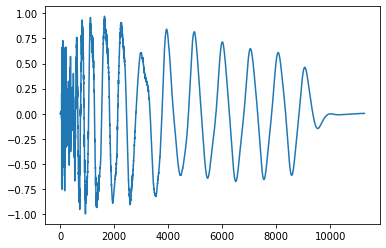

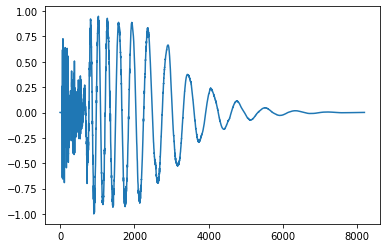

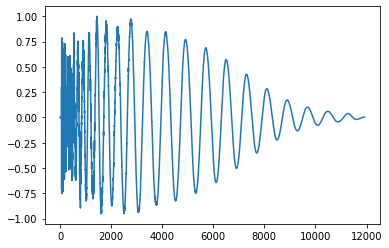

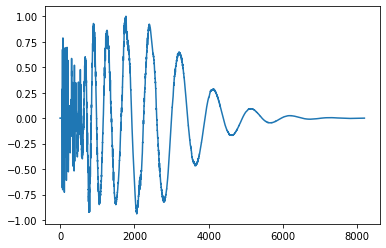

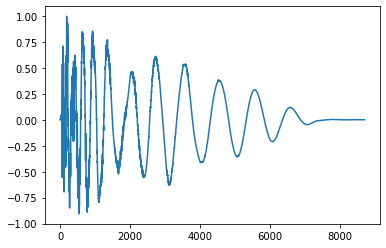

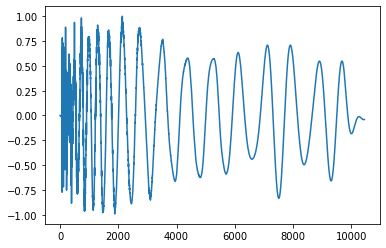

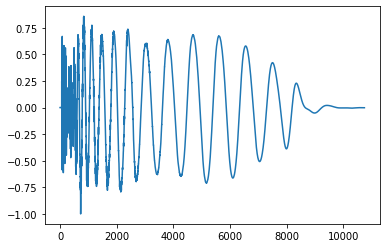

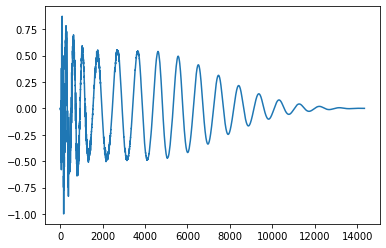

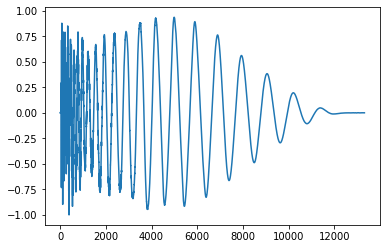

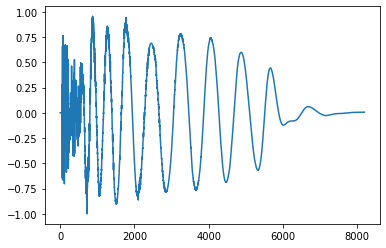

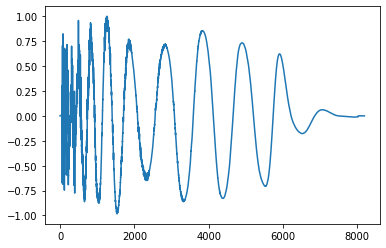

In [65]:
batch = next(train_gen_a)
print(batch)
for b in batch['X']:
    plt.plot(b)
    plt.show()

In [76]:
def a():
    y = 0
    while True:
        y = y+1
        yield y

def b():
    yield next(a())



1


In [86]:
x = next(b())
print(x)

1
